# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import dill
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 10 #50
thresholds = np.round(np.arange(0.6,1.00001,0.025), 2)
penalty = 'l1'

### Utility functions

In [2]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [3]:
# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [4]:
# open radiomics data
dfRad = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20221122_1628_allRegions_volFracApprox/radiomicFeatures/radiomicFeatures.csv'))
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# open reproducibility data
dfRadRep = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20221122_2037_repro_volFracApprox/radiomicFeatures/radiomicFeatures.csv'))
dfRadRep.drop(list(dfRadRep.filter(regex = 'source')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'histogram')), axis = 1, inplace = True)

## Choose between Sub-segmentation or approximate volume fractions 

In [5]:
# Option 1 - remove approximate volume fractions
if False:
    dfRad.drop(list(dfRad.filter(regex = 'ApproxVolFraction')), axis = 1, inplace=True)
    dfRadRep.drop(list(dfRadRep.filter(regex = 'ApproxVolFraction')), axis = 1, inplace=True)
    print('Using sub-segmentation volume fractions')
    
# Option 2 - the rest of the code will be horrible to re-configure for the approximate volume fraction column names
# so paste in the approximate values into the column names for the sub-segmentation volume fractions then delete the
# approximate columns
if True:
    dfRad['lesion_sarcomaFeature_low enhancingVolumeFraction'] = dfRad['lesion_sarcomaFeature_lowApproxVolFraction']
    dfRad['lesion_sarcomaFeature_high enhancingVolumeFraction'] = dfRad['lesion_sarcomaFeature_highApproxVolFraction']
    dfRad['lesion_sarcomaFeature_calcificationVolumeFraction'] = dfRad['lesion_sarcomaFeature_calcApproxVolFraction']
    #
    dfRad.drop('lesion_sarcomaFeature_lowApproxVolFraction', axis=1, inplace=True)
    dfRad.drop('lesion_sarcomaFeature_highApproxVolFraction', axis=1, inplace=True)
    dfRad.drop('lesion_sarcomaFeature_calcApproxVolFraction', axis=1, inplace=True)

    dfRadRep['lesion_sarcomaFeature_low enhancingVolumeFraction'] = dfRadRep['lesion_sarcomaFeature_lowApproxVolFraction']
    dfRadRep['lesion_sarcomaFeature_high enhancingVolumeFraction'] = dfRadRep['lesion_sarcomaFeature_highApproxVolFraction']
    dfRadRep['lesion_sarcomaFeature_calcificationVolumeFraction'] = dfRadRep['lesion_sarcomaFeature_calcApproxVolFraction']
    #
    dfRadRep.drop('lesion_sarcomaFeature_lowApproxVolFraction', axis=1, inplace=True)
    dfRadRep.drop('lesion_sarcomaFeature_highApproxVolFraction', axis=1, inplace=True)
    dfRadRep.drop('lesion_sarcomaFeature_calcApproxVolFraction', axis=1, inplace=True)

    print('Using approximate volume fractions')

    

Using approximate volume fractions


## Compute ICCs and remove unreproducible features

In [6]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)

dfRad.shape

(170, 90)

## Log transform positive skewed parameters

In [7]:
for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad[feat+'_log'] = np.log(dfRad[feat])
        dfRad.drop(feat, axis=1, inplace=True)

# this is heavily skewed, but has minimum value -87
dfRad['lesion_original_glcm_ClusterShade_log'] = np.log(dfRad['lesion_original_glcm_ClusterShade']+90)
dfRad.drop('lesion_original_glcm_ClusterShade', axis=1, inplace=True)

## Create output and copy code

In [8]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))
    os.mkdir(os.path.join(outputFolder, 'figures'))
    
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection.ipynb'))

    file = os.path.join(os.path.abspath(""), 'fit_LR_groupSelection_correlationThresholds.py')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'fit_LR_groupSelection_correlationThresholds.py'))

    user = os.path.expanduser("~")
    file = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

## Run classifications

### Tumour type: LMS v.s LPS
### Standard radiomics features

In [9]:
if False:
    # merge clinical and radiomics data into single frame
    df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)

    target = 'subtype'
    featureSet = 'lesion_original'

    df = df.filter(regex=featureSet + '|' + target)

    settings = {'n_splits':n_splits, 
                'n_repeats':n_repeats,
                'thresholds':thresholds,
                'penalty':penalty
               }

    textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
    settings['groupHierarchy'] = ['shape',
                                  'firstorder',
                                  textureStr,
                                  'shape|firstorder',
                                  'shape|' + textureStr,
                                  'firstorder|' + textureStr,
                                  '']

    quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_TumourType.pickle')

    if os.path.exists(quickLoadFile):
        with open(quickLoadFile, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(quickLoadFile, 'wb') as handle:
                pickle.dump(result, handle)

    resultStandardType = copy.deepcopy(result)

    del result

    plotResultExperiments(resultStandardType, 
                          titleStr='subtype: LMS vs. LPS, standard radiomics features',
                          outputFile=os.path.join(outputFolder, 'figures', 'subtype_standard.pdf'))

    bestCoef, pdFreq = displayOneExperiment(resultStandardType)
    pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
    display(pdFreq.style.hide_index())

### Tumour type: LMS v.s LPS
### Volume fraction and standard radiomics features

Threshold = 0.6
VolumeFraction|texture
AUROC = 0.925 ± 0.0303

Threshold = 0.7
VolumeFraction|texture
AUROC = 0.932 ± 0.0207

Threshold = 0.8
VolumeFraction|texture
AUROC = 0.944 ± 0.0219

Threshold = 0.9
VolumeFraction|texture
AUROC = 0.93 ± 0.0327

Threshold = 1.0
VolumeFraction|texture
AUROC = 0.919 ± 0.0363



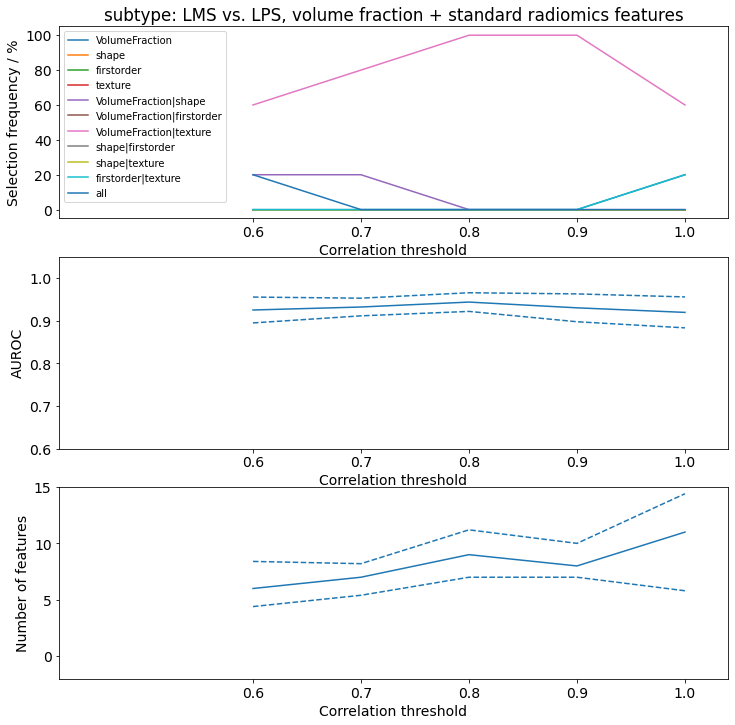

Threshold = 0.8
AUROC (CV) = 0.94359

Feature group = VolumeFraction|texture



In [10]:
if True:
    # merge clinical and radiomics data into single frame
    df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)

    target = 'subtype'
    featureSet = 'lesion_original|sarcomaFeature'

    df = df.filter(regex=featureSet + '|' + target)

    # remove one of the volume fraction features as it is co-linear with the others
    df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

    settings = {'n_splits':n_splits, 
                'n_repeats':n_repeats,
                'thresholds':thresholds,
                'penalty':penalty
               }

    quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_TumourType.pickle')

    if os.path.exists(quickLoadFile):
        with open(quickLoadFile, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(quickLoadFile, 'wb') as handle:
                pickle.dump(result, handle)

    resultVolFracType = copy.deepcopy(result)

    del result
    
    plotResultExperiments(resultVolFracType, 
                          titleStr = target + ': LMS vs. LPS, volume fraction + standard radiomics features',
                          outputFile=os.path.join(outputFolder, 'figures', 'subtype_standard_volFrac.pdf'))


    bestCoef, pdFreq = displayOneExperiment(resultVolFracType)
    pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
    display(pdFreq.style.hide_index())

### Tumour grade: 1 v.s 2 or 3
### Standard radiomics features

In [11]:
if False:
    # merge clinical and radiomics data into single frame
    df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)

    target = 'Grade1vs23'
    featureSet = 'lesion_original'

    df['Grade1vs23'] = df['Grade'] == 1

    df = df.filter(regex=featureSet + '|' + target)

    settings = {'n_splits':n_splits, 
                'n_repeats':n_repeats,
                'thresholds':thresholds,
                'penalty':penalty
               }

    textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
    settings['groupHierarchy'] = ['shape',
                                  'firstorder',
                                  textureStr,
                                  'shape|firstorder',
                                  'shape|' + textureStr,
                                  'firstorder|' + textureStr,
                                  '']

    quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_Grade1vs23.pickle')

    if os.path.exists(quickLoadFile):
        with open(quickLoadFile, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(quickLoadFile, 'wb') as handle:
                pickle.dump(result, handle)

    resultStandardGrade_1vs23 = copy.deepcopy(result)

    del result

    plotResultExperiments(resultStandardGrade_1vs23, 
                          titleStr = 'grade 1 vs. 2 or 3 standard radiomics features',
                          outputFile=os.path.join(outputFolder, 'figures', 'grade1v23_standard.pdf'))

    bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_1vs23)
    pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
    display(pdFreq.style.hide_index())

### Tumour grade: 1 or 2 v.s 3
### Standard radiomics features

In [12]:
if False:
    # merge clinical and radiomics data into single frame
    df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)

    target = 'Grade12vs3'
    featureSet = 'lesion_original'

    df[target] = df['Grade'] != 3

    df = df.filter(regex=featureSet + '|' + target)

    settings = {'n_splits':n_splits, 
                'n_repeats':n_repeats,
                'thresholds':thresholds,
                'penalty':penalty
               }

    textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
    settings['groupHierarchy'] = ['shape',
                                  'firstorder',
                                  textureStr,
                                  'shape|firstorder',
                                  'shape|' + textureStr,
                                  'firstorder|' + textureStr,
                                  '']

    quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_Grade12vs3.pickle')

    if os.path.exists(quickLoadFile):
        with open(quickLoadFile, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(quickLoadFile, 'wb') as handle:
                pickle.dump(result, handle)

    resultStandardGrade_12vs3 = copy.deepcopy(result)

    del result


    plotResultExperiments(resultStandardGrade_12vs3, 
                          titleStr = 'grade 1 or 2 vs. 3 standard radiomics features',
                          outputFile=os.path.join(outputFolder, 'figures', 'grade12vs3_standard.pdf'))

    bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_12vs3)
    pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
    display(pdFreq.style.hide_index())

### Tumour grade: 1 v.s 2 or 3
### Volume fractions and standard radiomics features

In [13]:
if True:
    # merge clinical and radiomics data into single frame
    df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)

    target = 'Grade1vs23'
    featureSet = 'lesion_original|sarcomaFeature'

    df['Grade1vs23'] = df['Grade'] == 1

    df = df.filter(regex=featureSet + '|' + target)

    # remove one of the volume fraction features as it is co-linear with the others
    df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

    settings = {'n_splits':n_splits, 
                'n_repeats':n_repeats,
                'thresholds':thresholds,
                'penalty':penalty
               }

    quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_Grade1vs23.pickle')

    if os.path.exists(quickLoadFile):
        with open(quickLoadFile, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(quickLoadFile, 'wb') as handle:
                pickle.dump(result, handle)

    resultVolumeFractionGrade_1vs23 = copy.deepcopy(result)

    del result

    plotResultExperiments(resultVolumeFractionGrade_1vs23, 
                          titleStr = 'grade 1 vs. 2 or 3 volume fractions + standard radiomics features',
                          outputFile=os.path.join(outputFolder, 'figures', 'grade1vs23_standard_volFrac.pdf'))

    bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_1vs23)
    pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
    display(pdFreq.style.hide_index())

Threshold = 0.6
all
AUROC = 0.844 ± 0.0849

Threshold = 0.7
all
AUROC = 0.839 ± 0.0523

Threshold = 0.8
all
AUROC = 0.827 ± 0.0632

Threshold = 0.9
VolumeFraction|texture
AUROC = 0.821 ± 0.0917



KeyboardInterrupt: 

### Tumour grade: 1 or 2 v.s 3
### Volume fractions + standard radiomics features 

In [ ]:
if True:
    # merge clinical and radiomics data into single frame
    df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)

    target = 'Grade12vs3'
    featureSet = 'lesion_original|sarcomaFeature'

    df[target] = df['Grade'] != 3

    df = df.filter(regex=featureSet + '|' + target)

    # remove one of the volume fraction features as it is co-linear with the others
    df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

    settings = {'n_splits':n_splits, 
                'n_repeats':n_repeats,
                'thresholds':thresholds,
                'penalty':penalty
               }

    quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_Grade12vs3.pickle')

    if os.path.exists(quickLoadFile):
        with open(quickLoadFile, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(quickLoadFile, 'wb') as handle:
                pickle.dump(result, handle)

    resultVolumeFractionGrade_12vs3 = copy.deepcopy(result)

    del result

    plotResultExperiments(resultVolumeFractionGrade_12vs3, 
                          titleStr = 'grade 1 or 2 vs. 3 volume fraction + standard radiomics features',
                          outputFile=os.path.join(outputFolder, 'figures', 'grade12vs3_standard_volFrac.pdf'))


    bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_12vs3)
    pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
    display(pdFreq.style.hide_index())

## Save this notebook once it is completed

In [ ]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection.ipynb'))